# Preparación ambiente

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Importación dataset

In [3]:
data = pd.read_csv("../data/patient_covid.csv", sep = ",", low_memory=False) 

In [3]:
#data=pd.read_csv("../Data/patient.csv")

In [4]:
print(data.nunique())
print(data.shape)

inpatient                   2
agegroup_10-19              2
agegroup_20-29              2
agegroup_30-39              2
agegroup_40-49              2
agegroup_50-59              2
agegroup_60-69              2
agegroup_70-79              2
agegroup_80-89              2
agegroup_90-99              2
asthma_Y                    2
cardiovascular_Y            2
chronic_kidney_failure_N    2
chronic_kidney_failure_Y    2
copd_Y                      2
covid_NOA                   2
covid_Y                     2
diabetes_N                  2
diabetes_Y                  2
hypertension_Y              2
immunosuppression_Y         2
obesity_Y                   2
other_diseases_N            2
other_diseases_Y            2
pneumonia_Y                 2
pregnant_Y                  2
sex_M                       2
smoker_Y                    2
dtype: int64
(95244, 28)


# Preparación Datos

In [5]:
#Dropeo icu, intubated, death_date
data=data.drop(['icu','intubated','death_date'], axis=1)
print(data.columns)
data.shape

Index(['sex', 'patient_type', 'pneumonia', 'age', 'pregnant', 'diabetes',
       'copd', 'asthma', 'immunosuppression', 'hypertension', 'other_diseases',
       'cardiovascular', 'obesity', 'chronic_kidney_failure', 'smoker',
       'outcome'],
      dtype='object')


(95252, 16)

In [6]:
#99 a null y dropeo
cols=data.columns.difference(['age'])

df=(data[cols] == 99)
ix=df[df.any(axis=1)].index
print(ix)
data.drop(df.index[ix], axis=0, inplace=True)
data.shape

Int64Index([161, 174, 592, 609, 644, 13322, 15671, 27316], dtype='int64')


(95244, 16)

In [7]:
#Renombro columnas
data.rename(columns={"patient_type": "inpatient", "outcome": "covid"},inplace=True)

In [8]:
#Para predictivas: 1 -> Y, 2 -> N, 
cols = data.loc[:, data.columns.difference(['age', 'sex','inpatient'])].columns
#print(cols) 
data[cols] = data[cols].replace([1,2],['Y','N'])

#en sex: 1 -> F y 2-> M
data['sex']= data['sex'].replace([1,2],['F','M'])

#en pregnant : 98 -> N, 97 -> NA
data['pregnant'] = data['pregnant'].replace([98,97],['N','NA'])

# outcome: 3 -> NA
data['covid'] = data['covid'].replace([3],['NA'])

##Para target (inpatient): 1 -> 0, 2 -> 1
data['inpatient']= data['inpatient'].replace([1,2],[0,1])
data.head(5)

,sex,inpatient,pneumonia,age,pregnant,diabetes,copd,asthma,immunosuppression,hypertension,other_diseases,cardiovascular,obesity,chronic_kidney_failure,smoker,covid
0,M,0,N,42,NA,N,N,Y,N,N,N,N,N,N,N,Y
1,F,0,N,51,N,N,N,N,N,N,N,N,N,N,N,Y
2,M,1,N,51,NA,Y,N,N,N,Y,N,N,Y,N,N,Y
3,M,1,N,57,NA,Y,N,N,N,N,N,N,N,N,N,Y
4,F,1,N,44,N,Y,N,N,N,N,N,N,N,N,N,N


In [9]:
data.groupby(["sex","pregnant"])["pregnant"].count()

sex  pregnant
F    N           45914
     Y             976
M    NA          48354
Name: pregnant, dtype: int64

In [10]:
#creo categorias para edad por décadas (puede ser por etapa biologica niños-jovenes-adultos-ancianos)
data = data.assign(agegroup=pd.cut(data['age'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], right=False, labels=["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-79","80-89","90-99"]))

In [11]:
data.columns

Index(['sex', 'inpatient', 'pneumonia', 'age', 'pregnant', 'diabetes', 'copd',
       'asthma', 'immunosuppression', 'hypertension', 'other_diseases',
       'cardiovascular', 'obesity', 'chronic_kidney_failure', 'smoker',
       'covid', 'agegroup'],
      dtype='object')

In [12]:
#elimino age para no tener dummies
data.drop(["age"], axis=1, inplace=True)

In [13]:
data.columns

Index(['sex', 'inpatient', 'pneumonia', 'pregnant', 'diabetes', 'copd',
       'asthma', 'immunosuppression', 'hypertension', 'other_diseases',
       'cardiovascular', 'obesity', 'chronic_kidney_failure', 'smoker',
       'covid', 'agegroup'],
      dtype='object')

In [14]:
#creo variables dummies de todas las columnas menos la target
data = pd.get_dummies(data=data, columns= data.columns.difference(["inpatient"]),drop_first = True)

In [15]:
data.columns

Index(['inpatient', 'agegroup_10-19', 'agegroup_20-29', 'agegroup_30-39',
       'agegroup_40-49', 'agegroup_50-59', 'agegroup_60-69', 'agegroup_70-79',
       'agegroup_80-89', 'agegroup_90-99', 'asthma_Y', 'cardiovascular_Y',
       'chronic_kidney_failure_N', 'chronic_kidney_failure_Y', 'copd_Y',
       'covid_NA', 'covid_Y', 'diabetes_N', 'diabetes_Y', 'hypertension_Y',
       'immunosuppression_Y', 'obesity_Y', 'other_diseases_N',
       'other_diseases_Y', 'pneumonia_Y', 'pregnant_NA', 'pregnant_Y', 'sex_M',
       'smoker_Y'],
      dtype='object')

# Creación variables X e Y

Eliminamos las columnas death_date, intubated y icu (por su correlación lineal con intubated)

In [5]:
x=data.drop(["inpatient"],axis=1)
y=data["inpatient"]
y=pd.DataFrame(y)
y

,inpatient
0,0
1,0
2,1
3,1
4,1
...,...
95239,1
95240,1
95241,1
95242,0


In [8]:
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y)
print ("X_train:" , x_train.shape[0])
print ("y_train:" , y_train.shape[0])
print ("X_test:" , x_test.shape[0])
print ("y_test:" , y_test.shape[0])

X_train: 71433
y_train: 71433
X_test: 23811
y_test: 23811


In [9]:
y_train=pd.DataFrame(y_train)
y_train

,inpatient
36665,0
9536,1
8245,0
40855,0
55647,1
...,...
37384,0
86463,0
73892,0
51126,1


In [19]:
#y_train=y_train.astype('float')
#y_test=y_test.astype('float')

In [11]:
print ("Logistic Regression Score:", score_lr)

Logistic Regression Score: 0.8724539078577128


## GridSearch Para KNN

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

In [24]:
knn=KNeighborsClassifier()

k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']
param_grid = dict(n_neighbors=k_range, weights=weight_options)

folds=StratifiedKFold(n_splits=10, random_state=19, shuffle=True)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}


In [26]:
grid = GridSearchCV(knn, param_grid, cv=folds, scoring='accuracy')

In [28]:
#esto tarda una hora más o menos en correr
grid.fit(x_train, y_train)
y_pred_grid = grid.predict(x_test)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=19, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20]},
             scoring='accuracy')

In [31]:
display(grid.best_score_,grid.best_params_,grid.best_estimator_)

0.8700702898093902

In [ ]:
print(confusion_matrix(y_test, y_pred_grid))
print (classification_report(y_test, y_pred_grid))

In [ ]:
random = RandomizedSearchCV(knn, param_grid, n_iter=10, cv=folds, random_state=19)
random.fit(X_train, y_train)
y_pred_grid_random = random.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, y_pred_grid_random))
print (classification_report(y_test, y_pred_grid_random))

In [ ]:
display(random.best_score_,random.best_params_,random.best_estimator_)

## Logistic Regression

In [10]:
#Logistic regression
#scaler = StandardScaler() (no uso estandarización, porque son todas variables dummies, y no voy a usar regularizaci)
#x_trainstd = scaler.fit_transform(x_train)
#x_teststd = scaler.transform(x_test)
lr = LogisticRegression()
lr.fit(x_train, y_train)
score_lr= lr.score(x_test, y_test)

In [13]:
y_pred_lr = lr.predict(x_test)

In [14]:
y_pred_lr_proba = lr.predict_proba(x_test)

In [15]:
print("AS LR:\n", accuracy_score(y_test, y_pred_lr))

AS LR:
 0.8724539078577128


In [16]:
print("CM LR:\n", confusion_matrix(y_test, y_pred_lr))

CM LR:
 [[16714   778]
 [ 2259  4060]]


In [17]:
lr.intercept_

array([0.74145545])

In [18]:
lr.coef_

array([[-1.21278034, -1.87350461, -1.83046525, -1.48283807, -1.04974137,
        -0.62492073, -0.1375193 ,  0.21215074,  0.52409109, -0.07858179,
         0.15527063, -0.4004359 ,  0.84591516,  0.60547438,  0.42511745,
         0.63328075, -0.94002296, -0.31042149,  0.19068032,  1.00486099,
         0.12214743, -0.68719393, -0.20292526,  3.47343743,  1.83260978,
         0.30217391,  0.03702216]])

In [19]:
print("LR:\n", classification_report(y_test,y_pred_lr))

LR:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92     17492
           1       0.84      0.64      0.73      6319

    accuracy                           0.87     23811
   macro avg       0.86      0.80      0.82     23811
weighted avg       0.87      0.87      0.87     23811



In [20]:
print ("F1 Score LR:", f1_score(y_test,y_pred_lr))

F1 Score LR: 0.7277942099130592


In [22]:
#LR
probs_lr=lr.predict_proba(x_test)
preds_lr=probs_lr[:,1]
fpr_lr,tpr_lr, threshold_lr =metrics.roc_curve(y_test, y_pred_lr)
roc_auc_lr=metrics.auc(fpr_lr,tpr_lr)

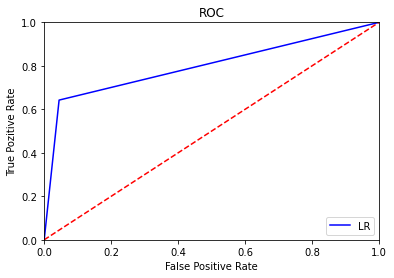

In [23]:
plt.title("ROC")

plt.plot(fpr_lr, tpr_lr, 'b', label="LR" % roc_auc_lr)

plt.legend(loc="lower right")
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Pozitive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Machine Learning Algorithms

In [ ]:
#Naive Bayes
nb=MultinomialNB()
nb.fit(x_train, y_train)
score_nb=nb.score(x_test,y_test)

#KNN (poner en n_neighbors el best_params_ de GridSearch)
knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train,y_train)
score_knn=knn.score(x_test,y_test)

#Logistic regression
scaler = StandardScaler()
x_trainstd = scaler.fit_transform(x_train)
x_teststd = scaler.transform(x_test)
lr = LogisticRegression()
lr.fit(x_trainstd, y_train)
score_lr= lr.score(x_teststd, y_test)

#Score
print ("Naive Bayes Acc Score:",score_nb)
print ("KNN Acc Score:",score_knn)
print ("Logistic Regression Score:", score_lr)

In [ ]:
y_pred_nb = nb.predict(x_test)
y_pred_knn = knn.predict(x_test)
y_pred_lr = lr.predict(x_teststd)

In [ ]:
print("AS NB:\n", accuracy_score(y_test, y_pred_nb))
print("AS KNN:\n", accuracy_score(y_test, y_pred_knn))
print("AS LR:\n", accuracy_score(y_test, y_pred_lr))

In [ ]:
#usar cross validation Stratified K-fold porque el target está desbalanceado
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.linear_model import LogisticRegression
iris=load_iris()
X=iris.data
Y=iris.target
logreg=LogisticRegression()
stratifiedkf=StratifiedKFold(n_splits=5)
score=cross_val_score(logreg,X,Y,cv=stratifiedkf)
print("Cross Validation Scores are {}".format(score))
print("Average Cross Validation score :{}".format(score.mean()))

## Confusion_matrix

In [ ]:
print("CM NB:\n", confusion_matrix(y_test, y_pred_nb))
print("CM KNN:\n", confusion_matrix(y_test, y_pred_knn))
print("CM LR:\n", confusion_matrix(y_test, y_pred_lr))

## Recall,Precision and F-1 Score


* Recall    =  TP / (TP + FN)
* Precision = TP / (TP + FP) 
* F-Measure = (2 * Precision * Recall) / (Precision + Recall)

In [ ]:
print("NB:\n", classification_report(y_test,y_pred_nb))
print("KNN:\n", classification_report(y_test,y_pred_knn))
print("LR:\n", classification_report(y_test,y_pred_lr))

In [ ]:
print ("F1 Score NB:", f1_score(y_test,y_pred_nb))
print ("F1 Score KNN:", f1_score(y_test,y_pred_knn))
print ("F1 Score LR:", f1_score(y_test,y_pred_lr))

## roc & auc

In [ ]:
#NB
probs_nb=nb.predict_proba(x_test)
preds_nb=probs_nb[:,1]
fpr_nb,tpr_nb, threshold_nb =metrics.roc_curve(y_test, y_pred_nb)
roc_auc_nb=metrics.auc(fpr_nb,tpr_nb)

#KNN
probs_knn=knn.predict_proba(x_test)
preds_knn=probs_knn[:,1]
fpr_knn,tpr_knn, threshold_knn =metrics.roc_curve(y_test, y_pred_knn)
roc_auc_knn=metrics.auc(fpr_knn,tpr_knn)

#LR
probs_lr=lr.predict_proba(x_teststd)
preds_lr=probs_lr[:,1]
fpr_lr,tpr_lr, threshold_lr =metrics.roc_curve(y_test, y_pred_lr)
roc_auc_lr=metrics.auc(fpr_lr,tpr_lr)

In [ ]:
plt.title("ROC")

plt.plot(fpr_nb, tpr_nb, 'g', label="NB" % roc_auc_nb)
plt.plot(fpr_knn, tpr_knn, 'r', label="KNN" % roc_auc_nb)
plt.plot(fpr_lr, tpr_lr, 'b', label="LR" % roc_auc_nb)

plt.legend(loc="lower right")
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Pozitive Rate')
plt.xlabel('False Positive Rate')
plt.show()